In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random

In [2]:
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from tensorflow.keras.datasets import fashion_mnist

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_test.shape

(10000, 28, 28)

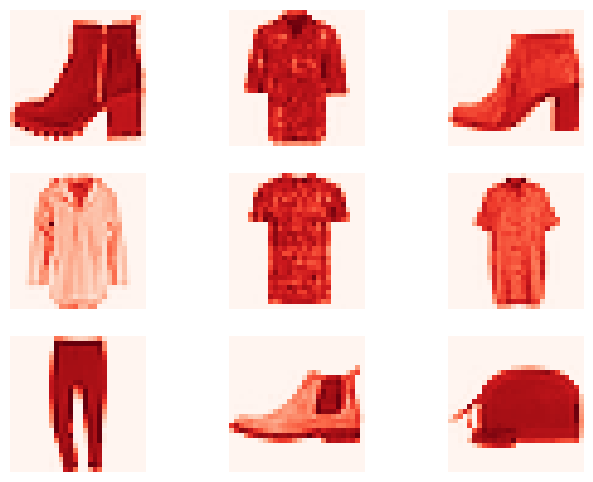

In [10]:
plt.figure(figsize = (8, 6))

random_samples = np.random.choice(60000, 9)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[random_samples[i]], cmap = "Reds")
    plt.axis("off")
plt.show()

In [11]:
data = np.concatenate([x_train, x_test], axis = 0)
data = np.expand_dims(data, -1).astype("float32") / 255

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
class SamplingLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [18]:
def build_encoder(latent_dims, encoder_inputs):
    l_1 = keras.models.Sequential(
        [
            layers.Conv2D(128, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Conv2D(64, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Flatten(),
            layers.Dense(256, activation = "relu"),
        ]
    )
    
    x = l_1(encoder_inputs)
    zmean = layers.Dense(latent_dims, name = "z_mean")(x)
    zlogvar = layers.Dense(latent_dims, name = "z_log_var")(x)
    z = SamplingLayer()([zmean, zlogvar])

    return keras.Model(encoder_inputs, [zmean, zlogvar, z], name = "encoder")
    

In [19]:
encoder_inputs = keras.Input(shape = (28,28,1))
encoder = build_encoder(2, encoder_inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 256)          878144      ['input_2[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 2)            514         ['sequential[0][0]']             
                                                                                                  
 z_log_var (Dense)              (None, 2)            514         ['sequential[0][0]']             
                                                                                            

In [20]:
def build_decoder(latent_inputs):
    l_2 =  keras.models.Sequential(
        [
            layers.Dense(7*7*64, activation = "relu", input_shape = (latent_inputs.shape[1],)),
            layers.Reshape((7,7,64)),
            layers.Conv2DTranspose(128, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same"),
            layers.Conv2DTranspose(1, 3, activation = "sigmoid", strides = 2, padding = "same"),
        ]
    )

    return keras.Model(latent_inputs, l_2(latent_inputs), name = "decoder")

In [21]:
latent_inputs = keras.Input(shape = (2,))
decoder = build_decoder(latent_inputs)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 1)         157633    
                                                                 
Total params: 157,633
Trainable params: 157,633
Non-trainable params: 0
_________________________________________________________________
